# Emirates NBD

## Technical Assessment_Senior Data Engineer

In [190]:
import findspark
findspark.init()

In [191]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import to_date, col # conversion of data types like Posting Date
from pyspark.sql.functions import round # round up numeric columns e.g "Salary Range From" and "Salary Range To"
from pyspark.sql.functions import avg, min, max, mean, stddev # salary distribution per job posting
from pyspark.sql.functions import desc # for sorting descending
#from pyspark.sql.functions import monotonically_increasing_id # Used for manifulating the Dataframe rows
from pyspark.sql.functions import when, lower, corr # correlation between the higher degree and the salary
from pyspark.sql.functions import trim # Use to remove any leading or trailing white space in a column
from pyspark.ml.feature import StringIndexer #correlation coefficient between different columns (string and integer) columns
from pyspark.sql.functions import current_date, date_sub, year, date_format, current_timestamp # Used for calculating dataframe from the last 2 years, 
from pyspark.sql.functions import concat, lit # Data transformation - "Add Dollar Sign To Salary"
from pyspark.ml.feature import OneHotEncoder # Feature Engineering - Encoding Categorical Variables
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, ChiSqSelector, StandardScaler # Feature Engineering

# Feature Engineering - Feature Removal
from pyspark.ml import Pipeline

# Import data visualization library for analysis results.
import matplotlib.pyplot as plt


from pyspark.sql.functions import isnan, when, count, col # Feature Removal - Identifying features with a high number of missing values

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [192]:
# Load the dataset
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema=True)

#df.printSchema()

###  Change the datatype of some columns

In [89]:
# convert Posting Date column to date datatype
#df = df.withColumn("Posting Date", to_date(col("Posting Date"), "yyyy/MM/dd"))

# convert Salary Range From column to integer datatype
# df = df.withColumn("Salary Range From", df["Salary Range From"].cast("integer"))

# convert Salary Range To column to integer datatype
# df = df.withColumn("Salary Range To", df["Salary Range To"].cast("integer"))
#df.printSchema()

### Convert the "Salary Range From" and "Salary Range To" columns to annual salaries where "Salary Frequency" is either "Daily" or "Hourly" 

In [90]:
# Define the conversion rates

hourly_to_annual = 2080 # assuming 40 hours per week, 52 weeks per year
daily_to_annual = 260 # assuming 5 days per week, 52 weeks per year

# Convert the "Salary Range From" column to annual salary
df = df.withColumn("Salary Range From",
                   when(col("Salary Frequency") == "Hourly", round(col("Salary Range From")) * hourly_to_annual)
                   .when(col("Salary Frequency") == "Daily", round(col("Salary Range From")) * daily_to_annual)
                   .otherwise(col("Salary Range From")))

# Convert the "Salary Range To" column to annual salary
df = df.withColumn("Salary Range To",
                   when(col("Salary Frequency") == "Hourly", round(col("Salary Range To")) * hourly_to_annual)
                   .when(col("Salary Frequency") == "Daily", round(col("Salary Range To")) * daily_to_annual)
                   .otherwise(col("Salary Range To")))

# Drop the original "Salary Range From" and "Salary Range To" columns
#df = df.drop("Salary Range From", "Salary Range To")

#df.groupBy("Salary Frequency").count().show()

### Sample function

In [ ]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [ ]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [ ]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result

# Data Exploration

### Provide a detailed analysis of source data: Column values (eg: Numerical vs character), categorical columns, etc.

In [130]:
# Getting root of columns with data types

df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

In [475]:
# Getting list of columns and printing

dt = df.dtypes
print("dtypes result:", dt)

dtypes result: [('Job ID', 'int'), ('Agency', 'string'), ('Posting Type', 'string'), ('# Of Positions', 'int'), ('Business Title', 'string'), ('Civil Service Title', 'string'), ('Title Code No', 'string'), ('Level', 'string'), ('Job Category', 'string'), ('Full-Time/Part-Time indicator', 'string'), ('Salary Range From', 'double'), ('Salary Range To', 'double'), ('Salary Frequency', 'string'), ('Work Location', 'string'), ('Division/Work Unit', 'string'), ('Job Description', 'string'), ('Minimum Qual Requirements', 'string'), ('Preferred Skills', 'string'), ('Additional Information', 'string'), ('To Apply', 'string'), ('Hours/Shift', 'string'), ('Work Location 1', 'string'), ('Recruitment Contact', 'string'), ('Residency Requirement', 'string'), ('Posting Date', 'string'), ('Post Until', 'string'), ('Posting Updated', 'string'), ('Process Date', 'string')]


In [474]:
# Printing DataFrame structure
print("DataFrame structure:", df)

dtypes result: [('Job ID', 'int'), ('Agency', 'string'), ('Posting Type', 'string'), ('# Of Positions', 'int'), ('Business Title', 'string'), ('Civil Service Title', 'string'), ('Title Code No', 'string'), ('Level', 'string'), ('Job Category', 'string'), ('Full-Time/Part-Time indicator', 'string'), ('Salary Range From', 'double'), ('Salary Range To', 'double'), ('Salary Frequency', 'string'), ('Work Location', 'string'), ('Division/Work Unit', 'string'), ('Job Description', 'string'), ('Minimum Qual Requirements', 'string'), ('Preferred Skills', 'string'), ('Additional Information', 'string'), ('To Apply', 'string'), ('Hours/Shift', 'string'), ('Work Location 1', 'string'), ('Recruitment Contact', 'string'), ('Residency Requirement', 'string'), ('Posting Date', 'string'), ('Post Until', 'string'), ('Posting Updated', 'string'), ('Process Date', 'string')]
DataFrame structure: DataFrame[Job ID: int, Agency: string, Posting Type: string, # Of Positions: int, Business Title: string, Civil

### Whats the number of jobs posting per category (Top 10)?

In [91]:
# Group the data by category and count the number of job postings
category_counts = df.groupBy("Job Category").count().alias("count")

# Sort the category counts in descending order and show the top 10 categories
##top_categories = category_counts.orderBy(desc("count")).limit(10)
top_categories = category_counts.sort("count", ascending=False).limit(10)

# Display the top categories and their counts
top_categories.show()


+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  504|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Building Operatio...|  181|
|Finance, Accounti...|  169|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+



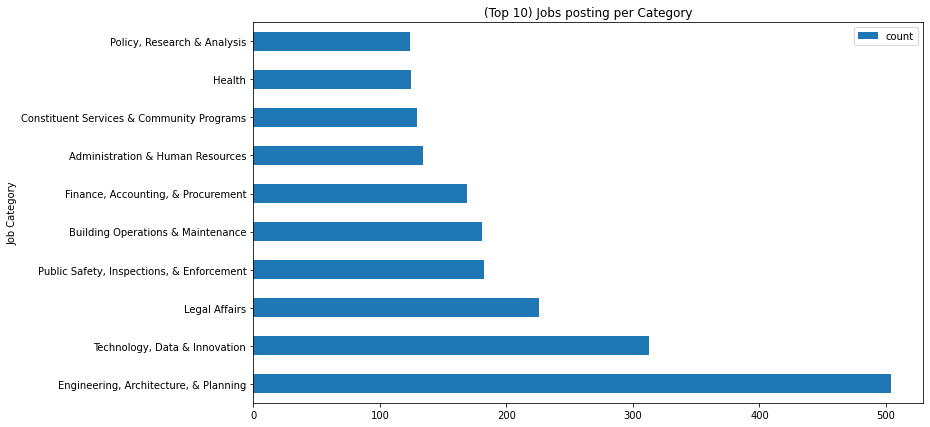

In [92]:

# Convert the PySpark DataFrame to a Pandas DataFrame in order to plot the graph
plot_top_categories = top_categories.toPandas()

# plot the number of job postings per category using Matplotlib 
plot_top_categories = top_categories.toPandas() \
        .plot(kind="barh", title ="(Top 10) Jobs posting per Category" , x="Job Category", y="count", figsize=(12, 7))

### Whats the salary distribution per job category?


In [99]:
# Remove the null values
salary_distribution = df.dropna()

# Compute the average salary from Salary Range From" and "Salary Range To" columns
salary_distribution = salary_distribution.withColumn("Average Salary", (col("Salary Range From") + col("Salary Range To")) / 2)

# Group by job category and calculate the  average, maximum, and minimum salaries for each category
salary_distribution = salary_distribution.groupBy("Job Category").agg(round(avg("Average Salary"),1), max("Average Salary"), min("Average Salary"))
#.sum("Average Salary").withColumnRenamed("Average Salary", "Salary")#.alias("Average Salary")

# Sort by job category
salary_distribution = salary_distribution.orderBy("Job Category")

salary_distribution = salary_distribution.withColumnRenamed("round(avg(Average Salary), 1)", "Average Salary")
salary_distribution = salary_distribution.withColumnRenamed("max(Average Salary)", "Max Salary")
salary_distribution = salary_distribution.withColumnRenamed("min(Average Salary)", "Min Salary")

# Display the results
salary_distribution.show(truncate=70)


+----------------------------------------------------------------------+--------------+----------+----------+
|                                                          Job Category|Average Salary|Max Salary|Min Salary|
+----------------------------------------------------------------------+--------------+----------+----------+
|                                      Administration & Human Resources|       87718.5|  122966.5|   60761.0|
|Administration & Human Resources Constituent Services & Community P...|      100000.0|  100000.0|  100000.0|
|Administration & Human Resources Constituent Services & Community P...|      110000.0|  110000.0|  110000.0|
|Administration & Human Resources Engineering, Architecture, & Plann...|       68057.0|   68057.0|   68057.0|
|Administration & Human Resources Public Safety, Inspections, & Enfo...|      165000.0|  165000.0|  165000.0|
|                                     Building Operations & Maintenance|      108407.8|  151795.0|   54882.0|
|       Cl

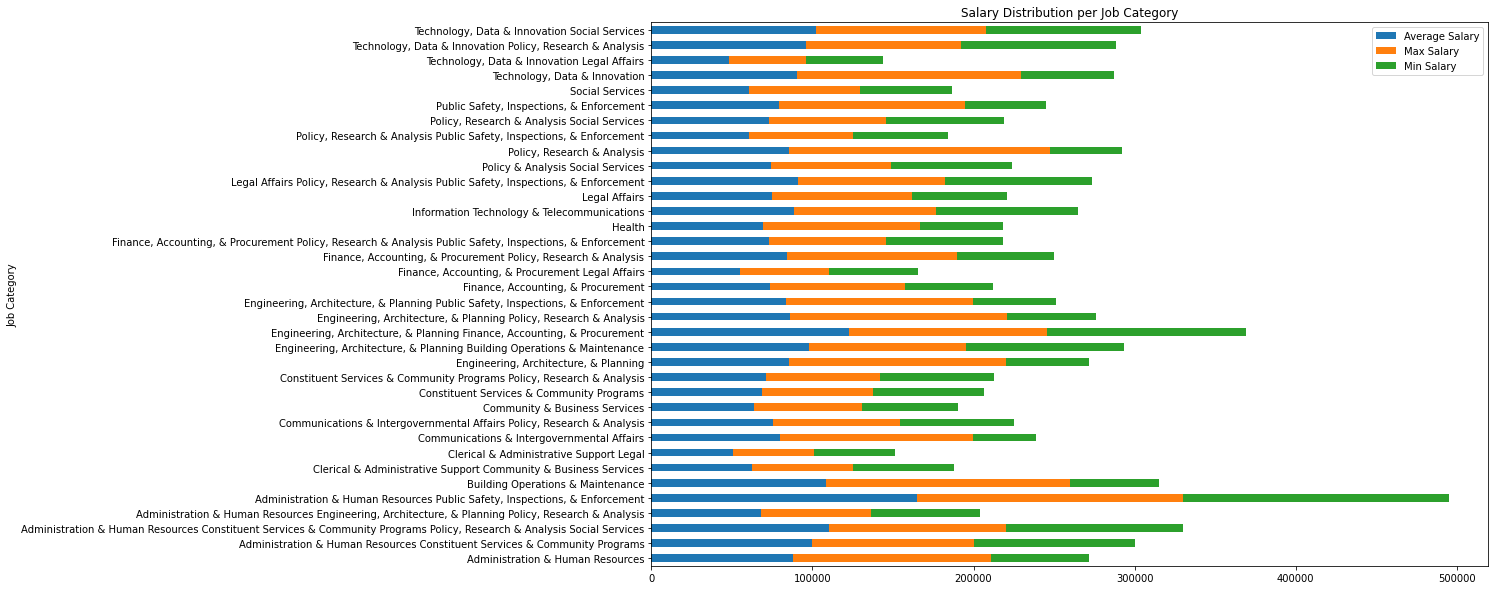

In [100]:
# Convert the PySpark DataFrame to a Pandas DataFrame in order to plot the graph
#salary_distribution = salary_distribution.toPandas()

# plot the number of job postings per category using Matplotlib 
plot_top_categories = salary_distribution.toPandas() \
.plot(kind="barh", stacked=True, title ="Salary Distribution per Job Category" , x="Job Category", figsize=(15, 10))

### Is there any correlation between the higher degree and the salary?

In [169]:
# Select the relevant columns
#minimum_qual_requirements_counts = df.select("Salary Range To", "Minimum Qual Requirements")

 
# Extract educational qualification from "Minimum Qual Requirements" column
df = df.withColumn("Education Level", when(lower(col("Minimum Qual Requirements")).contains("doctorate"), "PhD")
                      .when(lower(col("Minimum Qual Requirements")).contains("master"), "Master")
                      .when(lower(col("Minimum Qual Requirements")).contains("bachelor"), "Bachelor")
                      .when(lower(col("Minimum Qual Requirements")).contains("baccalaureate"), "Bachelor")
                      .when(lower(col("Minimum Qual Requirements")).contains("undergraduate"), "Undergraduate")
                      .when(lower(col("Minimum Qual Requirements")).contains("associate"), "Associate")
                      .when(lower(col("Minimum Qual Requirements")).contains("high school"), "High School")
                     .otherwise("Other"))



# Compute the average salary from Salary Range From" and "Salary Range To" columns
df = df.withColumn("Average Salary", (col("Salary Range From") + col("Salary Range To")) / 2)

# Calculate the mean salary for each educational qualification level
salary_by_education = df.groupBy("Education Level").mean("Average Salary")


# Filter out the row where the "Education Level" is 'Other
salary_by_education = salary_by_education.filter(col("Education Level") != 'Other')


#Sort by densending order
salary_by_education = salary_by_education.sort("avg(Average Salary)", ascending=False).withColumnRenamed("avg(Average Salary)", "Salary")


salary_by_education = salary_by_education.withColumn("Salary", salary_by_education["Salary"].cast("integer"))

#salary_by_education.printSchema()
salary_by_education = salary_by_education.withColumn("HigherDegree", when(col("Education Level") == 'PhD',5)
                      .when(col("Education Level") == 'Master', 4 )
                      .when(col("Education Level") == 'Bachelor', 3)
                      .when(col("Education Level") == 'Associate', 2)
                      .when(col("Education Level") == 'Undergraduate', 1)
                      .when(col("Education Level") == 'High School', 0)
                      .otherwise("Other"))

salary_by_education.show()

#salary_by_education = salary_by_education.withColumn('HigherDegree', salary_by_education['HigherDegree'].cast('integer'))

# Convert Education Level column to numerical column using StringIndexer
indexer = StringIndexer(inputCol="Education Level", outputCol="Education_Level_Index")
indexed = indexer.fit(salary_by_education).transform(salary_by_education)

# Calculate correlation coefficient between columns
corr = indexed.select([col("Education_Level_Index"),col("Salary")]).na.drop().corr("Salary", "Education_Level_Index")
corr1 = indexed.select([col("HigherDegree"),col("Salary")]).collect()[0][0]

#correlation = salary_by_education.select(corr('HigherDegree', 'Salary')).collect()[0][0]

print("Correlation coefficient: ", corr)
print("Correlation coefficient: ", corr1)
#print("Correlation coefficient: ", correlation)

correlation = df.corr("HigherDegree", "Salary")

# Print the result
print("Correlation between rank and salary: ", correlation)

# Please Note:: The returned values will be between -1 and 1, with 1 indicating a perfect positive correlation,
#               0 indicating no correlation, and -1 indicating a perfect negative correlation.

+---------------+------+------------+
|Education Level|Salary|HigherDegree|
+---------------+------+------------+
|            PhD| 84900|           5|
|         Master| 84372|           4|
|       Bachelor| 74392|           3|
|      Associate| 50351|           2|
|  Undergraduate| 48657|           1|
|    High School| 41708|           0|
+---------------+------+------------+

Correlation coefficient:  -0.8581418705400095
Correlation coefficient:  5


IllegalArgumentException: "requirement failed: Couldn't find column with name HigherDegree"

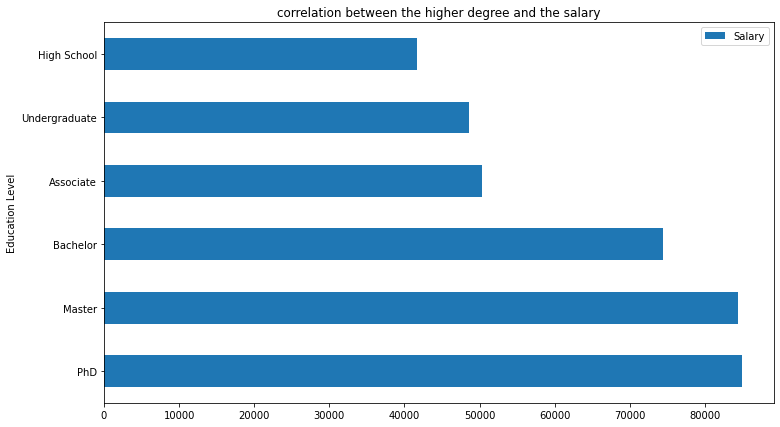

In [692]:
# plot the correlation between the higher degree and the salary using Matplotlib 
salary_by_education = salary_by_education.toPandas() \
        .plot(kind="barh", title ="correlation between the higher degree and the salary" , x="Education Level", y="Salary", figsize=(12, 7))

### Whats the job posting having the highest salary per agency?


In [114]:
#Convert the "Salary Range From" and "Salary Range To" columns to annual salaries where "Salary Frequency" is either "Daily" or "Hourly"

# Define the conversion rates

hourly_to_annual = 2080 # assuming 40 hours per week, 52 weeks per year
daily_to_annual = 260 # assuming 5 days per week, 52 weeks per year

# Convert the "Salary Range From" column to annual salary
df = df.withColumn("Salary Range From",
                   when(col("Salary Frequency") == "Hourly", round(col("Salary Range From")) * hourly_to_annual)
                   .when(col("Salary Frequency") == "Daily", round(col("Salary Range From")) * daily_to_annual)
                   .otherwise(col("Salary Range From")))

# Convert the "Salary Range To" column to annual salary
df = df.withColumn("Salary Range To",
                   when(col("Salary Frequency") == "Hourly", round(col("Salary Range To")) * hourly_to_annual)
                   .when(col("Salary Frequency") == "Daily", round(col("Salary Range To")) * daily_to_annual)
                   .otherwise(col("Salary Range To")))




# group the DataFrame by agency and find the highest salary for each agency
highest_salary = df.groupBy("Agency").agg(max("Salary Range From").alias("Highest Salary"))
#max_salary_per_agency = df.groupBy("Agency").max("Salary Range From")
#highest_salary_per_agency = df.groupBy("Agency").agg({"Salary Range From": "max"})

# Sort the data by the highest salary in descending order
highest_salary_per_agency = highest_salary.sort(desc("Highest Salary"))#.limit(20)

# display the results
highest_salary_per_agency.show(truncate=90)



+------------------------------+--------------+
|                        Agency|Highest Salary|
+------------------------------+--------------+
|DEPT OF ENVIRONMENT PROTECTION|      218587.0|
|             POLICE DEPARTMENT|      200000.0|
|DISTRICT ATTORNEY KINGS COUNTY|      175000.0|
|         NYC HOUSING AUTHORITY|      175000.0|
|                LAW DEPARTMENT|      164104.0|
|     OFFICE OF THE COMPTROLLER|      160000.0|
|   DEPARTMENT OF INVESTIGATION|      160000.0|
| DEPT OF HEALTH/MENTAL HYGIENE|      157725.0|
|      DEPARTMENT OF SANITATION|      151840.0|
|      DEPARTMENT FOR THE AGING|      150371.0|
|   DEPT OF CITYWIDE ADMIN SVCS|      140140.0|
|  NYC EMPLOYEES RETIREMENT SYS|      130000.0|
|      DEPARTMENT OF CORRECTION|      130000.0|
|HOUSING PRESERVATION & DVLPMNT|      130000.0|
|    DEPT OF PARKS & RECREATION|      128000.0|
|    FINANCIAL INFO SVCS AGENCY|      120000.0|
|         DEPARTMENT OF FINANCE|      120000.0|
|   TAXI & LIMOUSINE COMMISSION|      12

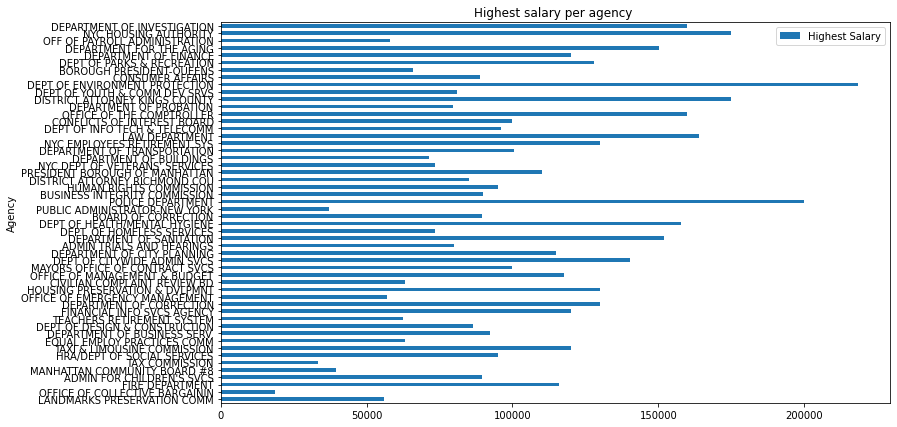

In [115]:
# plot the job posting having the highest salary per agency using Matplotlib 
highest_salary = highest_salary.toPandas() \
        .plot(kind="barh", title ="Highest salary per agency " , x="Agency", y="Highest Salary", figsize=(12, 7))

### Whats the job positings average salary per agency for the last 2 years?

In [187]:
#df = df.withColumn("Posting Date", to_date(col("Posting Date"), "yyyy-MM-dd"))

last_2years = df.select(year(max("Posting Date"))).collect()[0][0]

# Selecting relevant columns and filtering for the last 2 years
df = df.select("Agency", "Salary Range To","Salary Range From", "Posting Date") \
       .filter(year("Posting Date") >= last_2years-2)

# Computing the average salary per agency and orderBy "Average Salary" column
avg_salary = df.groupBy("Agency") \
               .agg(round(avg(col("Salary Range From") + col("Salary Range To"))) \
               .alias("Average Salary")) \
               .orderBy("Average Salary", ascending=False)

# Displaying the results
avg_salary.show()

2019
2017
+--------------------+--------------+
|              Agency|Average Salary|
+--------------------+--------------+
|CONFLICTS OF INTE...|      270000.0|
|BUSINESS INTEGRIT...|      190000.0|
|FINANCIAL INFO SV...|      187989.0|
|MAYORS OFFICE OF ...|      174714.0|
|    CONSUMER AFFAIRS|      174221.0|
|OFFICE OF THE COM...|      170471.0|
|HOUSING PRESERVAT...|      169764.0|
|DEPT OF INFO TECH...|      166751.0|
|PRESIDENT BOROUGH...|      165000.0|
|DEPT OF YOUTH & C...|      161396.0|
|      LAW DEPARTMENT|      161314.0|
|NYC HOUSING AUTHO...|      157076.0|
|HUMAN RIGHTS COMM...|      156188.0|
|DEPT OF DESIGN & ...|      155614.0|
|NYC EMPLOYEES RET...|      149551.0|
|DISTRICT ATTORNEY...|      141383.0|
|DISTRICT ATTORNEY...|      140662.0|
|OFFICE OF MANAGEM...|      139532.0|
|TEACHERS RETIREME...|      138157.0|
|DEPARTMENT OF PRO...|      136459.0|
+--------------------+--------------+
only showing top 20 rows



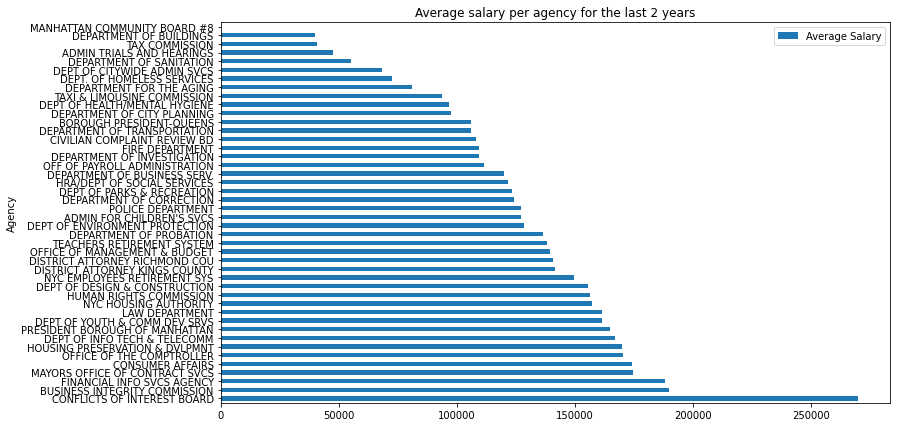

In [188]:
avg_salary = avg_salary.toPandas() \
        .plot(kind="barh", title ="Average salary per agency for the last 2 years" , x="Agency", y="Average Salary", figsize=(12, 7))

### What are the highest paid skills in the US market?


In [195]:
# Drop any rows with missing values
highest_paid_skills = df.dropna()

# Trim the "Preferred Skills" column 
highest_paid_skills = highest_paid_skills.withColumn("Preferred Skills", trim(highest_paid_skills["Preferred Skills"]))

# group by "Preferred Skills" and calculate the maximum "Salary Range To"
highest_paid_skills = highest_paid_skills.groupBy("Preferred Skills").max("Salary Range To")\
                        .withColumnRenamed("max(Salary Range To)", "Highest Salary") \
                        .sort("Highest Salary", ascending=False)

# show the result
highest_paid_skills.limit(20).show(truncate=90)


+------------------------------------------------------------------------------------------+--------------+
|                                                                          Preferred Skills|Highest Salary|
+------------------------------------------------------------------------------------------+--------------+
|                                                                                commercial|      224749.0|
|                                                                                managerial|      194395.0|
|     at least 18 months of which must have been in a managerial or administrative capacity|      186555.0|
|                                    18 months of which must have been in an administrative|      178873.0|
|                                                                        and City employees|      170000.0|
|"1. For Assignment to Assignment Level IV  - In addition to meeting the ""Qualification...|      161497.0|
|                           

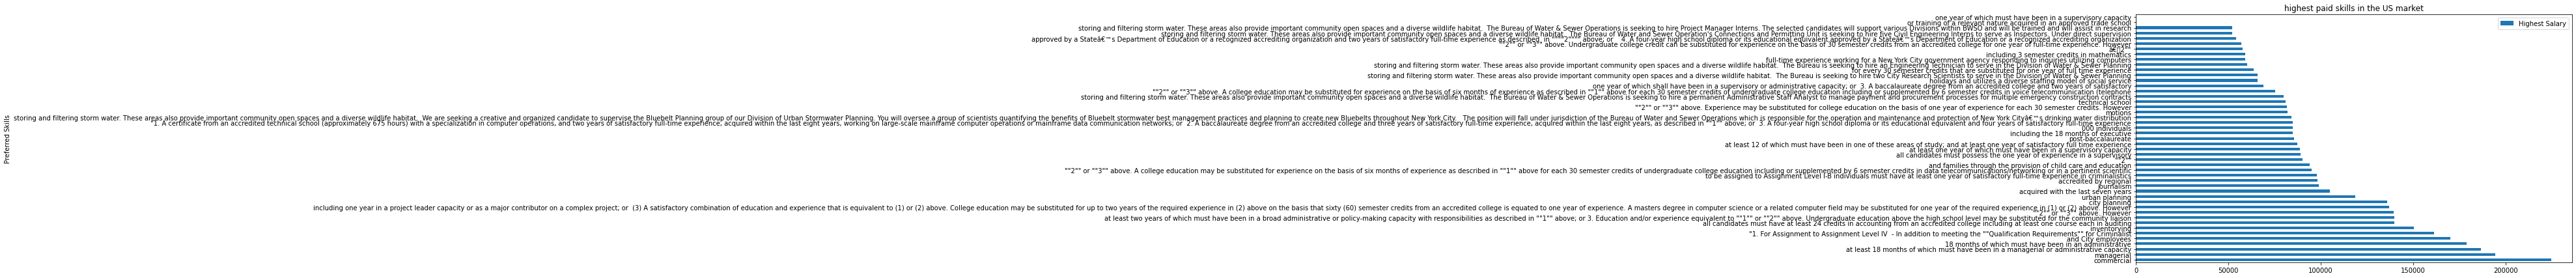

In [196]:
highest_paid_skills = highest_paid_skills.toPandas() \
        .plot(kind="barh", title ="highest paid skills in the US market" , x="Preferred Skills", y="Highest Salary", figsize=(12, 7))

# Data Processing

## Create functions to process your dataset (Cleaning, column pre-processing, data wrangling, transformation etc)

### Data Cleaning

In [135]:
def  drop_duplicate_rows(df):
    """
    This function cleans the dataset by removing any duplicate rows.
    """
    if df:
        return df.dropDuplicates()
    else:
        return None
    
def replace_null_values(df):
    """
    This function cleans the dataset by replacing any null values with an empty string.
    """
    if df:
        return df.fillna("")
    else:
        return None    

def remove_white_space(df, column_name):
    """
    This function cleans the dataset by remove any leading or trailing white space in all columns.
    """
    if df:
        for col in df.columns:
            
            return df.withColumn(column_name, trim(df[column_name]))
    else:
        return None
    
    
 
#df1 = remove_white_space(df, "Minimum Qual Requirements") 
#df1.select("Posting Date", "Salary Range To", "Minimum Qual Requirements").show()   

### Column pre-processing

In [136]:
def convert_columns_datatype(df):
    """
    This function handles pre-processing by converting columns to the required datatype format.
    """
    if df:
        # convert Posting Date column to date datatype
        df = df.withColumn("Posting Date", to_date(col("Posting Date"), "yyyy-MM-dd"))

        # convert Salary Range From column to integer datatype
        df = df.withColumn("Salary Range From", df["Salary Range From"].cast("integer"))

        # convert Salary Range To column to integer datatype
        df = df.withColumn("Salary Range To", df["Salary Range To"].cast("integer"))
        return df
    else:
        return None

df1 = convert_columns_datatype(df) 
df1.select("Posting Date", "Salary Range To").show()

+------------+---------------+
|Posting Date|Salary Range To|
+------------+---------------+
|        null|          65485|
|  2012-01-26|         162014|
|        null|          54580|
|        null|          54580|
|  2014-01-09|             35|
|  2014-01-09|             35|
|        null|          85053|
|  2013-12-20|          75083|
|        null|         110000|
|  2014-06-26|          49707|
|        null|          60000|
|        null|         131623|
|        null|         131623|
|  2014-10-09|             10|
|  2014-10-09|             10|
|  2014-10-08|          51981|
|        null|          53000|
|        null|          69000|
|  2014-11-18|          51981|
|        null|          95896|
+------------+---------------+
only showing top 20 rows



### Data Wrangling

In [152]:

# filter by column
def filter_by_column(df, column_name, column_value ):
    return df.filter(df[column_name] == column_value)

# Add "new average salary" column
def add_average_salary(df):
    # Compute the average salary from Salary Range From" and "Salary Range To" columns
    df = df.withColumn("Average Salary", (col("Salary Range From") + col("Salary Range To")) / 2)
    return df

#df1 = filter_by_column(df, "Salary Range To", 65485) 
#df1.select("Posting Date", "Salary Range To", "Salary Range From" ).show()
#df1 = add_average_salary(df) 
#df1.select("Posting Date", "Salary Range To", "Average Salary").show()

+--------------------+---------------+-----------------+
|        Posting Date|Salary Range To|Salary Range From|
+--------------------+---------------+-----------------+
|New York City res...|        65485.0|          42405.0|
+--------------------+---------------+-----------------+



### Data Transformation

In [345]:
# Data wrangling is the process of removing errors and combining complex data sets to make them more accessible and easier to analyze

In [361]:
# Select the relevant columns
select_salary = df.select("Salary Range To", "Salary Range From")

# Split the 'Salary Range From' and 'Salary Range To' columns into separate columns
# salary_from = df.withColumn("Salary Range From", split(col("Salary Range From"), "\$")[1].cast("integer"))
# salary_from.show()

# Add a "$" sign to the beginning of the "Salary" column
add_dollar_to_salary = select_salary.withColumn("Salary Range From", concat(lit("$"), df["Salary Range From"]))
add_dollar_to_salary = add_dollar_to_salary.withColumn("Salary Range To", concat(lit("$"), df["Salary Range To"]))

# Show the modified DataFrame
add_dollar_to_salary.show()

+---------------+-----------------+
|Salary Range To|Salary Range From|
+---------------+-----------------+
|         $65485|           $42405|
|        $162014|           $60740|
|         $54580|           $51907|
|         $54580|           $51907|
|            $35|              $35|
|            $35|              $35|
|         $85053|           $50598|
|         $75083|           $50623|
|        $110000|           $90000|
|         $49707|           $30683|
|         $60000|           $49492|
|        $131623|           $87203|
|        $131623|           $87203|
|            $10|               $8|
|            $10|               $8|
|         $51981|           $32086|
|         $53000|           $43292|
|         $69000|           $49492|
|         $51981|           $32086|
|         $95896|           $81290|
+---------------+-----------------+
only showing top 20 rows



### Apply atleast 3 feature engineering techniques


#### 3 Feature Engineering Techniques

1. Encoding Categorical Variables
2. Feature Scaling
3. Feature Selection

In [153]:
# 1. Encoding Categorical Variables

# Drop any rows with missing values
df = df.dropna()

# Select the relevant columns
select_columns = df.select('Agency','Business Title', 'Job Category', 'Salary Range From')

# encode agency column using StringIndexer
agency_indexer = StringIndexer(inputCol="Job Category", outputCol="JobCategoryID")
agency_stringIndexer = agency_indexer.fit(select_columns).transform(select_columns)

# encode agency column using OneHotEncoder
agency_encoder = OneHotEncoder(inputCol="JobCategoryID", outputCol="JobCategoryEncoder")
agency_hotEncoder = agency_encoder.transform(agency_stringIndexer)
agency_hotEncoder.sort("JobCategoryID", ascending=True).show()



+--------------------+--------------------+--------------------+-----------------+-------------+------------------+
|              Agency|      Business Title|        Job Category|Salary Range From|JobCategoryID|JobCategoryEncoder|
+--------------------+--------------------+--------------------+-----------------+-------------+------------------+
|TAXI & LIMOUSINE ...|IT Technical Support|Technology, Data ...|          26.1615|          0.0|    (35,[0],[1.0])|
|   POLICE DEPARTMENT|Computer Speciali...|Technology, Data ...|          81951.0|          0.0|    (35,[0],[1.0])|
|DEPARTMENT OF TRA...|Junior Telecom Su...|Technology, Data ...|          43392.0|          0.0|    (35,[0],[1.0])|
|DEPARTMENT OF CIT...|   Senior Programmer|Technology, Data ...|          85000.0|          0.0|    (35,[0],[1.0])|
|     FIRE DEPARTMENT|Oracle Middleware...|Technology, Data ...|          96020.0|          0.0|    (35,[0],[1.0])|
|DEPARTMENT OF COR...|Desktop Support T...|Technology, Data ...|        

In [ ]:
2. # Feature Scaling

In [31]:
# Drop any rows with missing values
df = df.dropna()

# Select the relevant columns
#select_columns = df.select('Business Title', 'Job Category', 'Salary Range From')

# select the columns to be scaled
columns_to_scale = ['Salary Range From', 'Salary Range To']

# assemble the selected columns into a vector column
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
salary_assembled = assembler.transform(df)

# instantiate a MinMaxScaler object
scaler = MinMaxScaler(inputCol="features", outputCol="salary_features")

# fit and transform the scaler on the assembled dataset
scaler_model = scaler.fit(salary_assembled)
salary_scaled = scaler_model.transform(salary_assembled)

# select the scaled feature column and any other required columns
salary_scaled.select(col("Job Category"), col("Agency"), col("Business Title"), col("salary_features")).show()

+--------------------+--------------------+--------------------+--------------------+
|        Job Category|              Agency|      Business Title|     salary_features|
+--------------------+--------------------+--------------------+--------------------+
|Finance, Accounti...|DEPT OF INFO TECH...|Deputy Director, ...|[0.309325,0.26685...|
|Community & Busin...|DEPT OF INFO TECH...|311 Call Center M...|[0.309325,0.30690...|
|Clerical & Admini...|DEPT OF INFO TECH...|  Research Assistant|[0.25034375,0.269...|
|Clerical & Admini...|DEPT OF INFO TECH...|311 Call Center M...|[0.33358125,0.320...|
|Community & Busin...|DEPT OF INFO TECH...|311 Call Center M...|[0.4,0.3158090304...|
|Policy & Analysis...|ADMIN FOR CHILDRE...|APA Foster Care P...|[0.37530625,0.395...|
|Policy & Analysis...|ADMIN FOR CHILDRE...|APA Foster Care P...|[0.37530625,0.395...|
|     Social Services|ADMIN FOR CHILDRE...|Asset Management ...|[0.29003125,0.300...|
|     Social Services|ADMIN FOR CHILDRE...|Asset Manag

In [ ]:
# 3. Feature Selection

In [154]:
# Drop any rows with missing values
df = df.dropna()

# Select relevant columns and convert to features vector
# assembler = VectorAssembler(inputCols=["# Of Positions", "Salary Range To", "Residency Requirement"], outputCol="features")
assembler = VectorAssembler(inputCols=["Salary Range To"], outputCol="features")
features_vector = assembler.transform(df).select( "Business Title", "Job Category", "features", "Salary Range From")

# Perform chi-squared feature selection
selector = ChiSqSelector(numTopFeatures=2, featuresCol="features", outputCol="selectedFeatures", labelCol="Salary Range From")
selected_features = selector.fit(features_vector).transform(features_vector)

# Show the selected features
selected_features.select( "Business Title","Job Category", "selectedFeatures").toPandas()

,Business Title,Job Category,selectedFeatures
0,"Deputy Director, Audits and Accounts","Finance, Accounting, & Procurement",[60000.0]
1,311 Call Center Manager,Community & Business Services,[69000.0]
2,Research Assistant,Clerical & Administrative Support Legal,[60611.0]
3,311 Call Center Manager,Clerical & Administrative Support Community & ...,[72000.0]
4,311 Call Center Manager,Community & Business Services,[71000.0]
...,...,...,...
229,Agency Attorney,Legal Affairs,[82137.0]
230,Agency Attorney,Legal Affairs,[82137.0]
231,Supervisor,"Finance, Accounting, & Procurement Legal Affairs",[59014.0]
232,TECH SUPPORT/SCHEDULER,"Technology, Data & Innovation",[85000.0]


### Features removal based on the exploration/ profiling.

In [71]:

# Count number of null values in each column
null_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()  
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Based on the EDA, create a list of features to remove.
# This can include features with high numbers of missing values,
# Drop the features
features_removal_df = df.drop("Posting Updated", "Post Until", "Process Date", "Work Location 1", "Recruitment Contact")

# Show the resulting DataFrame
features_removal_df.toPandas()

+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+-----------------------------+-----------------+---------------+----------------+-------------+------------------+---------------+-------------------------+----------------+----------------------+--------+-----------+---------------+-------------------+---------------------+------------+----------+---------------+------------+
|Job ID|Agency|Posting Type|# Of Positions|Business Title|Civil Service Title|Title Code No|Level|Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|Work Location|Division/Work Unit|Job Description|Minimum Qual Requirements|Preferred Skills|Additional Information|To Apply|Hours/Shift|Work Location 1|Recruitment Contact|Residency Requirement|Posting Date|Post Until|Posting Updated|Process Date|
+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+---------

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Residency Requirement,Posting Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,None,None,...,110 William St. N Y,Strategy & Analytics,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,â€¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",None,None,New York City residency is generally required ...
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,None,F,...,110 William St. N Y,Tech Talent Pipeline,The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,None,"In addition to applying through this website, ...",None,New York City residency is generally required ...,2012-01-26T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...,may be substituted for six months of the expe...,all candidates must have a minimum of two yea...,"""Click the """"Apply Now"""" button.""",None
3,132292,NYC HOUSING AUTHORITY,Internal,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...,may be substituted for six months of the expe...,all candidates must have a minimum of two yea...,"""Click the """"Apply Now"""" button.""",None
4,133921,NYC HOUSING AUTHORITY,Internal,50,Temporary Painter,PAINTER,91830,0,Maintenance & Operations,F,...,DMP-Contract & Analysis Unit,Dept of Management & Planning,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,SPECIAL NOTE: 1. This is a temporary assig...,"""Click the """"Apply Now"""" button.""",None,NYCHA has no residency requirement.,2014-01-09T00:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2941,426214,HOUSING PRESERVATION & DVLPMNT,External,1,Senior Mechanical Cost Estimator,CONSTRUCTION PROJECT MANAGER,34202,2,"Engineering, Architecture, & Planning",F,...,100 Gold Street,"Eng, Design Const Supp",The New York City Department of Housing Preser...,"""1. A four-year high school diploma or its edu...",candidates must have one additional year of s...,in addition to meeting the Qualification Requ...,candidates must have two additional years of ...,license suspension or an accident record,None,Apply Online.
2942,426214,HOUSING PRESERVATION & DVLPMNT,Internal,1,Senior Mechanical Cost Estimator,CONSTRUCTION PROJECT MANAGER,34202,2,"Engineering, Architecture, & Planning",F,...,100 Gold Street,"Eng, Design Const Supp",The New York City Department of Housing Preser...,"""1. A four-year high school diploma or its edu...",candidates must have one additional year of s...,in addition to meeting the Qualification Requ...,candidates must have two additional years of ...,license suspension or an accident record,None,Apply Online.
2943,426223,HOUSING PRESERVATION & DVLPMNT,Internal,1,Conversion Coordinator,COMMUNITY COORDINATOR,56058,0,Building Operations & Maintenance,F,...,100 Gold Street,Operations,The New York City Departme

### Store your processed data into a target file

In [ ]:
target_file = "/dataset/nyc-jobs_output.csv"

# Write the output to a CSV file
df.write.csv(target_file, header=True, mode="overwrite")